example_build_planet
--------------------

For Earth we have well-constrained one-dimensional density models.  This allows us to
calculate pressure as a funcion of depth.  Furthermore, petrologic data and assumptions
regarding the convective state of the planet allow us to estimate the temperature.

For planets other than Earth we have much less information, and in particular we
know almost nothing about the pressure and temperature in the interior.  Instead, we tend
to have measurements of things like mass, radius, and moment-of-inertia.  We would like
to be able to make a model of the planet's interior that is consistent with those
measurements.

However, there is a difficulty with this.  In order to know the density of the planetary
material, we need to know the pressure and temperature.  In order to know the pressure,
we need to know the gravity profile.  And in order to the the gravity profile, we need
to know the density.  This is a nonlinear problem which requires us to iterate to find
a self-consistent solution.

Here we show an example that does this, using the planet Mercury as motivation.


*Uses:*

* :doc:`mineral_database`
* :class:`burnman.composite.Composite`
* :func:`burnman.material.Material.evaluate`


In general, there are three portions of a Burnman script:

1) Define a set of pressures and temperatures at which we want to calculate elastic properties

2) Setup a composite of minerals (or “rock”) and calculate its elastic properties at those pressures and temperatures.

3) Plot those elastic properties, and compare them to a seismic model, in this case PREM

In [ ]:
%matplotlib inline

In [1]:
# This file is part of BurnMan - a thermoelastic and thermodynamic toolkit for the Earth and Planetary Sciences
# Copyright (C) 2012 - 2015 by the BurnMan team, released under the GNU
# GPL v2 or later.



from __future__ import absolute_import
from __future__ import print_function

import os
import sys
sys.path.insert(1, os.path.abspath('burnman-0.9.0'))

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline

import burnman
import burnman.minerals as minerals
from build_mantle import *
import matplotlib.gridspec as gridspec

In [2]:
class Earth(Planet):
    
    def __init__(self, n_slices):
        # The constructor takes the number of depth slices which will
        # be used for the calculation.  More slices will generate more
        # accurate profiles, but it will take longer.
        
        self.cmb = 3481.e3              # Guess for the radius of the core-mantle-boundary
        self.tz = 5701.e3               # Transition Zone boundary between upper and lower mantle
        self.outer_radius = 6371.e3     # Outer radius of the planet
        
        self.radii = np.linspace(0.e3, self.outer_radius, n_slices)     # Radius list
        self.pressures = np.linspace( 300.0e9, 0.0, n_slices)            # initial guess at pressure profile


        '''
        Vary composition here!
        '''
        
        # Simple upper mantle with pure olivine
        fraction_fe = 0.12               # amount of fayalite Fe2SiO4
        fraction_mg = 1.0-fraction_fe   # amount of forsterite Mg2SiO4
        olivine  = minerals.SLB_2011.mg_fe_olivine()
        olivine.set_composition([fraction_mg,fraction_fe])
        self.upper_mantle = burnman.Composite([olivine],[1.0])

        # Simple lower mantle with pure perovskite
        fraction_fe = 0.12                               # amount of FeSiO3
        fraction_al = 0.                                # amount of Al2O3
        fraction_mg = 1.0 - fraction_fe - fraction_al   # amount of MgSiO3
        bridgmanite = minerals.SLB_2011.mg_fe_bridgmanite()
        bridgmanite.set_composition([fraction_mg, fraction_fe, fraction_al])
        self.lower_mantle = burnman.Composite([bridgmanite],[1.0]) #phases: list of :class:`burnman.Material`, fractions: list of floats

                             
        # We will ignore the core here and just use PREM values
        self.core = burnman.seismic.PREM()


                                               

In [61]:
minerals.SLB_2011.ferropericlase?

In [3]:






# import PREM
prem = burnman.seismic.PREM()
depths = prem.internal_depth_list()


# Here we actually do the interation.  We make an instance
# of our Earth planet, then call generate_profiles.
# Emprically, 300 slices and 5 iterations seem to do
# a good job of converging on the correct profiles.
n_slices = 300
n_iterations = 5
earth = Earth(n_slices)
earth.generate_profiles(n_iterations)

# These are the actual observables
# from the model, that is to say,
# the total mass of the planet and
# the moment of inertia factor,
# or C/MR^2
observed_mass = 5.972e24
observed_moment = 0.3307  # From Margot. et al, 2012

print(("Total mass of the planet: %.2e, or %.1f%% of the observed mass" %
      (earth.mass, earth.mass / observed_mass * 100.)))
print(("Moment of inertia factor of the planet: %.3g, or %0.1f%% of the observed factor" %
      (earth.moment_of_inertia_factor, earth.moment_of_inertia_factor / observed_moment * 100.)))






/Users/dansandiford/anaconda/lib/python2.7/site-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Total mass of the planet: 5.97e+24, or 99.9% of the observed mass
Moment of inertia factor of the planet: 0.331, or 100.0% of the observed factor


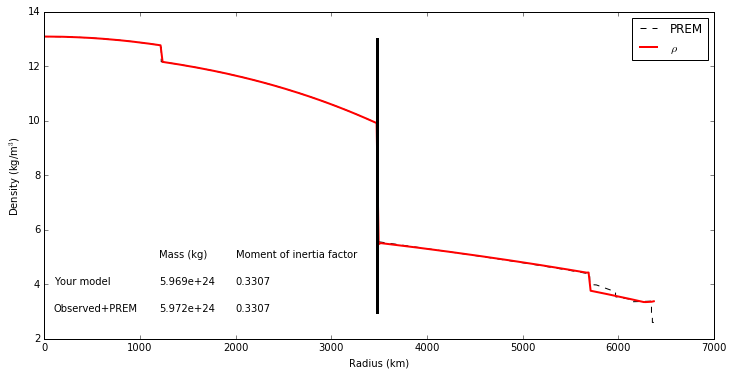

In [16]:
# Come up with axes for the final plot. You can add axes here to plot velocities or pressures.
figure = plt.figure(figsize=(12, 10))
ax1 = plt.subplot2grid((5, 3), (0, 0), colspan=3, rowspan=3)


ax1.plot((6371.e3-depths)/1.e3, prem.density(depths)/1.e3, color = 'k', linestyle = '--', label='PREM')

# Plot density, vphi, and vs for the planet.
ax1.plot(earth.radii / 1.e3, earth.densities /
         1.e3, label=r'$\rho$', linewidth=2., color = 'r')



# Also plot a black line for the CMB
ylimits = [3., 13.]
ax1.plot([earth.cmb / 1.e3, earth.cmb / 1.e3], ylimits, 'k', linewidth=3.)


#Write mass and moment of intertia on plot
ax1.text(1200,5, 'Mass (kg)')
ax1.text(2000,5, 'Moment of inertia factor')
ax1.text(100,4, 'Your model')
ax1.text(100,3, 'Observed+PREM')
ax1.text(1200,4, '%.3e'% (earth.mass))
ax1.text(2000,4, '%.4g' %(earth.moment_of_inertia_factor))
ax1.text(1200,3, '%.3e'% (observed_mass))
ax1.text(2000,3, '%.4g' %(observed_moment))

ax1.legend()
ax1.set_ylabel("Density (kg/m$^3$)")
ax1.set_xlabel("Radius (km)")


plt.show()


In [41]:
#Make a few changes to the Earth Class

In [15]:
class Earth(Planet):
    
    def __init__(self, n_slices, um__fe, lm_fe):
        # The constructor takes the number of depth slices which will
        # be used for the calculation.  More slices will generate more
        # accurate profiles, but it will take longer.
        
        self.cmb = 3481.e3              # Guess for the radius of the core-mantle-boundary
        self.tz = 5701.e3               # Transition Zone boundary between upper and lower mantle
        self.outer_radius = 6371.e3     # Outer radius of the planet
        
        self.radii = np.linspace(0.e3, self.outer_radius, n_slices)     # Radius list
        self.pressures = np.linspace( 300.0e9, 0.0, n_slices)            # initial guess at pressure profile


        '''
        Vary composition here!
        '''
        
        # Simple upper mantle with pure olivine
        fraction_fe = um__fe             # amount of fayalite Fe2SiO4
        fraction_mg = 1.0-fraction_fe   # amount of forsterite Mg2SiO4
        olivine  = minerals.SLB_2011.mg_fe_olivine()
        olivine.set_composition([fraction_mg,fraction_fe])
        self.upper_mantle = burnman.Composite([olivine],[1.0])

        # Simple lower mantle with pure perovskite
        fraction_fe = lm_fe                               # amount of FeSiO3
        fraction_al = 0.                                # amount of Al2O3
        fraction_mg = 1.0 - fraction_fe - fraction_al   # amount of MgSiO3
        bridgmanite = minerals.SLB_2011.mg_fe_bridgmanite()
        bridgmanite.set_composition([fraction_mg, fraction_fe, fraction_al])
        self.lower_mantle = burnman.Composite([bridgmanite],[1.0])
                             
        # We will ignore the core here and just use PREM values
        self.core = burnman.seismic.PREM()


                                               

In [30]:
earth1 = Earth(n_slices, um__fe=0.12, lm_fe=0.12)
earth1.generate_profiles(n_iterations)

earth2 = Earth(n_slices, um__fe=0.5, lm_fe=0.5)
earth2.generate_profiles(n_iterations)

## Plot densities

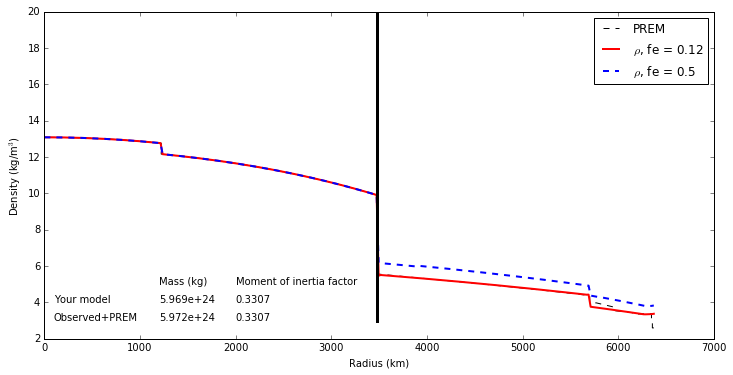

In [31]:
# Come up with axes for the final plot. You can add axes here to plot velocities or pressures.
figure = plt.figure(figsize=(12, 10))
ax1 = plt.subplot2grid((5, 3), (0, 0), colspan=3, rowspan=3)


ax1.plot((6371.e3-depths)/1.e3, prem.density(depths)/1.e3, color = 'k', linestyle = '--', label='PREM')

# Plot density, vphi, and vs for the planet.
ax1.plot(earth1.radii / 1.e3, earth1.densities /
         1.e3, label=r'$\rho$, ' + 'fe = 0.12' , linewidth=2., color = 'r')



# Plot density, vphi, and vs for the planet.
ax1.plot(earth2.radii / 1.e3, earth2.densities /
         1.e3, label=r'$\rho$, ' + 'fe = 0.5', linewidth=2., color = 'b', linestyle = '--')



# Also plot a black line for the CMB
ylimits = [3., 20.]
ax1.plot([earth.cmb / 1.e3, earth.cmb / 1.e3], ylimits, 'k', linewidth=3.)


#Write mass and moment of intertia on plot
ax1.text(1200,5, 'Mass (kg)')
ax1.text(2000,5, 'Moment of inertia factor')
ax1.text(100,4, 'Your model')
ax1.text(100,3, 'Observed+PREM')
ax1.text(1200,4, '%.3e'% (earth.mass))
ax1.text(2000,4, '%.4g' %(earth.moment_of_inertia_factor))
ax1.text(1200,3, '%.3e'% (observed_mass))
ax1.text(2000,3, '%.4g' %(observed_moment))

ax1.legend()
ax1.set_ylabel("Density (kg/m$^3$)")
ax1.set_xlabel("Radius (km)")


plt.show()


## Plot shear viscosities

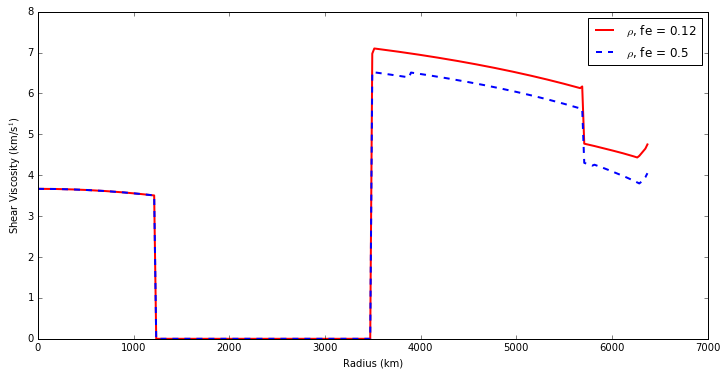

In [54]:
# Come up with axes for the final plot. You can add axes here to plot velocities or pressures.
figure = plt.figure(figsize=(12, 10))
ax1 = plt.subplot2grid((5, 3), (0, 0), colspan=3, rowspan=3)


#ax1.plot((6371.e3-depths)/1.e3, prem.density(depths)/1.e3, color = 'k', linestyle = '--', label='PREM')

# Plot density, vphi, and vs for the planet.
ax1.plot(earth1.radii / 1.e3, earth1.shear_velocity/
         1.e3, label=r'$\rho$, ' + 'fe = 0.12' , linewidth=2., color = 'r')



# Plot density, vphi, and vs for the planet.
ax1.plot(earth2.radii / 1.e3, earth2.shear_velocity /
         1.e3, label=r'$\rho$, ' + 'fe = 0.5', linewidth=2., color = 'b', linestyle = '--')



# Also plot a black line for the CMB
ylimits = [0., 8000.]
#ax1.plot([earth.cmb / 1.e3, earth.cmb / 1.e3], ylimits, 'k', linewidth=3.)


#Write mass and moment of intertia on plot
#ax1.text(1200,5, 'Mass (kg)')
#ax1.text(2000,5, 'Moment of inertia factor')
#ax1.text(100,4, 'Your model')
#ax1.text(100,3, 'Observed+PREM')
#ax1.text(1200,4, '%.3e'% (earth.mass))
#ax1.text(2000,4, '%.4g' %(earth.moment_of_inertia_factor))
#ax1.text(1200,3, '%.3e'% (observed_mass))
#ax1.text(2000,3, '%.4g' %(observed_moment))

ax1.legend()
ax1.set_ylabel("Shear Viscosity (km/s$^1$)")
ax1.set_xlabel("Radius (km)")


plt.show()

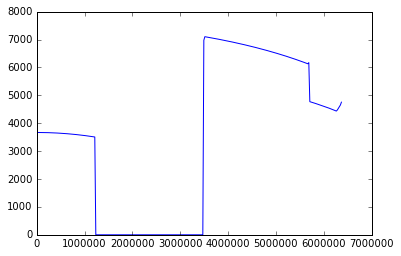

In [35]:
plt.plot(earth1.radii, earth1.shear_velocity)


In [62]:
bridgmanite = minerals.SLB_2011.mg_fe_bridgmanite()
bridgmanite.set_composition([0.12, 1 - 0.12, 0.])
#bridgmanite.H
